In [1]:
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from sklearn.utils import shuffle
from tensorflow.keras import utils
from tensorflow import concat
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
    
images = images.astype(np.float32)  

labels = utils.to_categorical(labels, 10)
labels = labels.astype(np.float32)

In [3]:
(images, labels) = shuffle(images, labels)

In [4]:
classes = ['Disturbed Galaxies','Merging Galaxies','Round Smooth Galaxies','In-between Round Smooth Galaxies','Cigar Shaped Smooth Galaxies','Barred Spiral Galaxies','Unbarred Tight Spiral Galaxies','Unbarred Loose Spiral Galaxies','Edge-on Galaxies without Bulge','Edge-on Galaxies with Bulge']
class_labels = {classes:i for classes, i in enumerate(classes)}#生成类别名字到标号的对应关系，是否正确对应未检查。
print(class_labels)

{0: 'Disturbed Galaxies', 1: 'Merging Galaxies', 2: 'Round Smooth Galaxies', 3: 'In-between Round Smooth Galaxies', 4: 'Cigar Shaped Smooth Galaxies', 5: 'Barred Spiral Galaxies', 6: 'Unbarred Tight Spiral Galaxies', 7: 'Unbarred Loose Spiral Galaxies', 8: 'Edge-on Galaxies without Bulge', 9: 'Edge-on Galaxies with Bulge'}


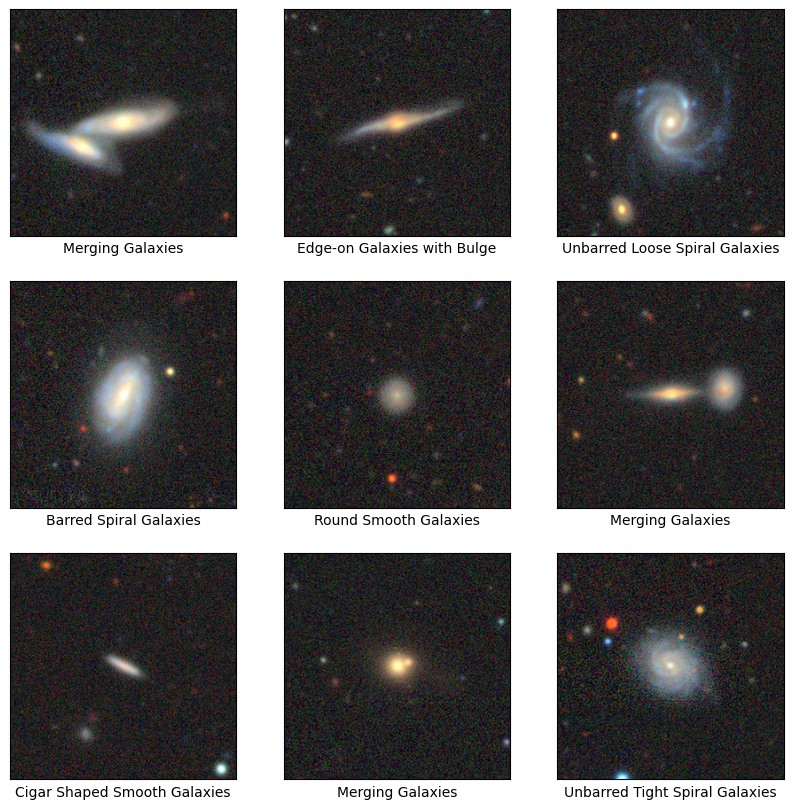

In [5]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i]/255.)
    plt.xlabel(class_labels[int(np.argwhere(labels[i]==1))])
plt.show()

In [6]:
train_datagen = ImageDataGenerator(
    #featurewise_center=True,#将输入数据的每个样本减去整个数据集的均值，使得数据的均值为0。
    #featurewise_std_normalization=True,#将输入数据的每个样本除以整个数据集的标准差，以使数据的标准差为1。
    rotation_range=180,#正负180度旋转
    width_shift_range=0.2,#左右偏移0.2个图像
    height_shift_range=0.2,#上下偏移0.2个图像
    horizontal_flip=True,#开启左右翻转
    rescale=1/255.,#将像素值处理到0到1
    validation_split=0.2,#0.2的训练集
)

train_datagen.fit(images)#调用 fit 方法来计算输入图像数据的统计信息，包括均值和标准差。

In [7]:
batch_size = 9

In [8]:
#mixup方法的核心
def mixup(batch_x, batch_y, alpha):
    batch_size = len(batch_x)
    lam = np.random.beta(alpha, alpha, size=batch_size)#以beta分布来计算lam值，这个值用来当比例

    index = np.random.permutation(batch_size)#生成一个打乱了的下标
    mixed_x = lam.reshape(batch_size, 1, 1, 1) * batch_x + (1 - lam.reshape(batch_size, 1, 1, 1)) * batch_x[index]#逐点混合图像
    mixed_y = lam.reshape(batch_size, 1) * batch_y + (1 - lam.reshape(batch_size, 1)) * batch_y[index]#混合标签

    return mixed_x, mixed_y

In [9]:
#获得数据生成器
generator = train_datagen.flow(images, labels, batch_size=batch_size,subset='training')

In [12]:
#获得下一个批次
batch_x, batch_y = next(generator)
mixed_x, mixed_y = mixup(batch_x, batch_y, 1)

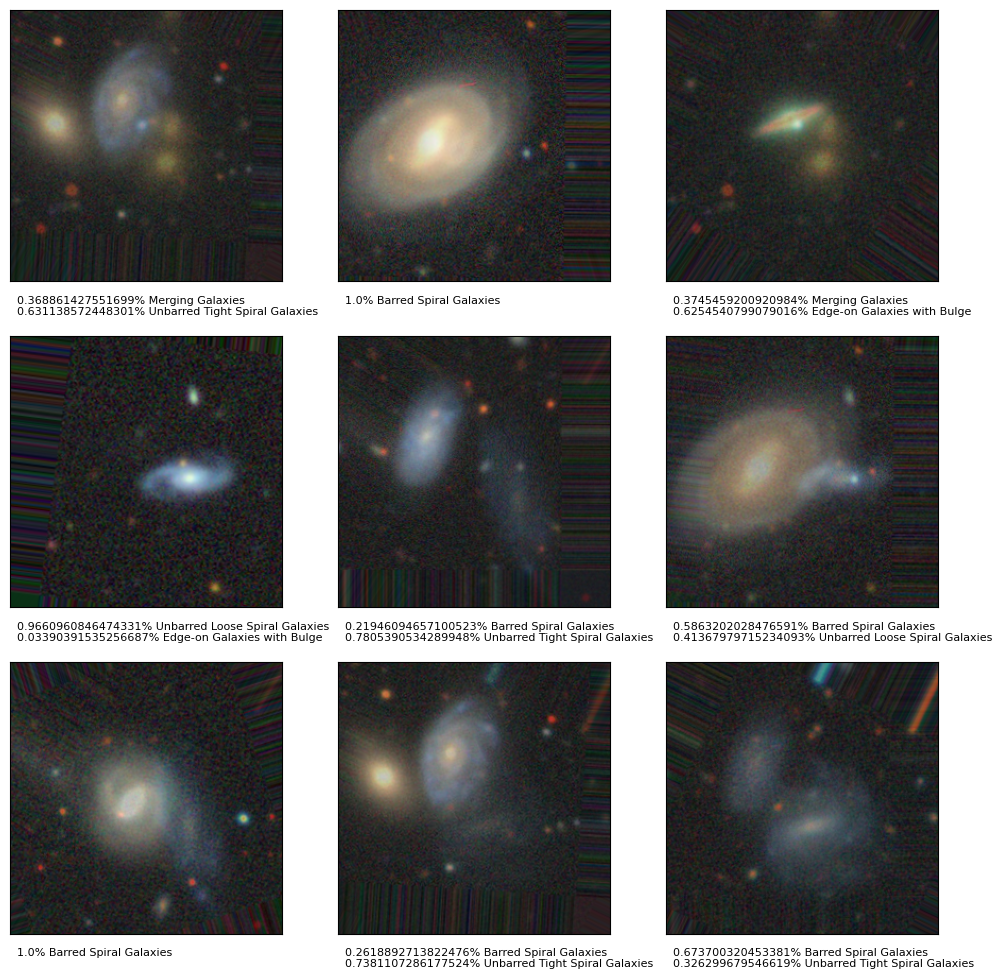

In [13]:
plt.figure(figsize=(12,12))
for i in range(batch_size):
    plt.subplot(int(math.sqrt(batch_size)),int(math.sqrt(batch_size)),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mixed_x[i])
    labels = []
    for j in range(10):
        if mixed_y[i][j]!=0:
            label = str(mixed_y[i][j])+'% '+class_labels[j]
            labels.append(label)
    plt.annotate('\n'.join(labels), xy=(0, 0), xytext=(5, -10),
                 xycoords='axes fraction', textcoords='offset points',
                 ha='left', va='top', fontsize=8)
plt.show()